In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import eli5

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
import lightgbm as lgb
import xgboost as xgb

import gc
import os

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [4]:
os.chdir('D:\\Github\\google NCAA\\raw_data')

In [5]:
tourney_result = pd.read_csv("MDataFiles_Stage1\\MNCAATourneyCompactResults.csv")

In [6]:
tourney_seed = pd.read_csv("MDataFiles_Stage1\\MNCAATourneySeeds.csv")

In [7]:
tourney_result = tourney_result.drop(['DayNum', 'WScore', 'LScore', 'WLoc', 'NumOT'], axis=1)
tourney_result = pd.merge(tourney_result, tourney_seed, left_on=['Season', 'WTeamID'], 
                          right_on=['Season', 'TeamID'], how='left')
tourney_result.rename(columns={'Seed':'WSeed'}, inplace=True)
tourney_result = tourney_result.drop('TeamID', axis=1)
tourney_result = pd.merge(tourney_result, tourney_seed, left_on=['Season', 'LTeamID'], 
                          right_on=['Season', 'TeamID'], how='left')
tourney_result.rename(columns={'Seed':'LSeed'}, inplace=True)
tourney_result = tourney_result.drop('TeamID', axis=1)
tourney_result

,Season,WTeamID,LTeamID,WSeed,LSeed
0,1985,1116,1234,X09,X08
1,1985,1120,1345,Z11,Z06
2,1985,1207,1250,W01,W16
3,1985,1229,1425,Y09,Y08
4,1985,1242,1325,Z03,Z14
...,...,...,...,...,...
2246,2019,1120,1246,Y05,Y02
2247,2019,1277,1181,W02,W01
2248,2019,1403,1277,X03,W02
2249,2019,1438,1120,Z01,Y05


In [8]:
def get_seed(x):
    return int(x[1:3])

tourney_result['WSeed'] = tourney_result['WSeed'].map(lambda x: get_seed(x))
tourney_result['LSeed'] = tourney_result['LSeed'].map(lambda x: get_seed(x))

In [9]:
season_result = pd.read_csv('MDataFiles_Stage1/MRegularSeasonCompactResults.csv')
season_win_result = season_result[['Season', 'WTeamID', 'WScore']]
season_lose_result = season_result[['Season', 'LTeamID', 'LScore']]
season_win_result.rename(columns={'WTeamID':'TeamID', 'WScore':'Score'}, inplace=True)
season_lose_result.rename(columns={'LTeamID':'TeamID', 'LScore':'Score'}, inplace=True)
season_result = pd.concat((season_win_result, season_lose_result)).reset_index(drop=True)
season_score = season_result.groupby(['Season', 'TeamID'])['Score'].sum().reset_index()

In [10]:
tourney_result = pd.merge(tourney_result, season_score, left_on=['Season', 'WTeamID'], 
                          right_on=['Season', 'TeamID'], how='left')
tourney_result.rename(columns={'Score':'WScoreT'}, inplace=True)
tourney_result = tourney_result.drop('TeamID', axis=1)
tourney_result = pd.merge(tourney_result, season_score, left_on=['Season', 'LTeamID'], 
                          right_on=['Season', 'TeamID'], how='left')
tourney_result.rename(columns={'Score':'LScoreT'}, inplace=True)
tourney_result = tourney_result.drop('TeamID', axis=1)

In [11]:
tourney_win_result = tourney_result.drop(['Season', 'WTeamID', 'LTeamID'], axis=1)
tourney_win_result.rename(columns={'WSeed':'Seed1', 'LSeed':'Seed2', 'WScoreT':'ScoreT1', 'LScoreT':'ScoreT2'}, inplace=True)

In [12]:
tourney_lose_result = tourney_win_result.copy()
tourney_lose_result['Seed1'] = tourney_win_result['Seed2']
tourney_lose_result['Seed2'] = tourney_win_result['Seed1']
tourney_lose_result['ScoreT1'] = tourney_win_result['ScoreT2']
tourney_lose_result['ScoreT2'] = tourney_win_result['ScoreT1']

In [13]:
tourney_win_result['Seed_diff'] = tourney_win_result['Seed1'] - tourney_win_result['Seed2']
tourney_win_result['ScoreT_diff'] = tourney_win_result['ScoreT1'] - tourney_win_result['ScoreT2']
tourney_lose_result['Seed_diff'] = tourney_lose_result['Seed1'] - tourney_lose_result['Seed2']
tourney_lose_result['ScoreT_diff'] = tourney_lose_result['ScoreT1'] - tourney_lose_result['ScoreT2']

In [14]:
tourney_win_result['result'] = 1
tourney_lose_result['result'] = 0
train_df = pd.concat((tourney_win_result, tourney_lose_result)).reset_index(drop=True)
train_df

,Seed1,Seed2,ScoreT1,ScoreT2,Seed_diff,ScoreT_diff,result
0,9,8,2156,2092,1,64,1
1,11,6,2040,1728,5,312,1
2,1,16,2045,1907,-15,138,1
3,9,8,1933,1915,1,18,1
4,3,14,2281,1824,-11,457,1
...,...,...,...,...,...,...,...
4497,2,5,2532,2682,-3,-150,0
4498,1,2,2839,2680,-1,159,0
4499,2,3,2680,2339,-1,341,0
4500,5,1,2682,2299,4,383,0


In [16]:
test_df = pd.read_csv('MDataFiles_Stage1/MSampleSubmissionStage1_2020.csv')

In [17]:
test_df['Season'] = test_df['ID'].map(lambda x: int(x[:4]))
test_df['WTeamID'] = test_df['ID'].map(lambda x: int(x[5:9]))
test_df['LTeamID'] = test_df['ID'].map(lambda x: int(x[10:14]))

In [18]:
test_df = pd.merge(test_df, tourney_seed, left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'], how='left')
test_df.rename(columns={'Seed':'Seed1'}, inplace=True)
test_df = test_df.drop('TeamID', axis=1)
test_df = pd.merge(test_df, tourney_seed, left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID'], how='left')
test_df.rename(columns={'Seed':'Seed2'}, inplace=True)
test_df = test_df.drop('TeamID', axis=1)
test_df = pd.merge(test_df, season_score, left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'], how='left')
test_df.rename(columns={'Score':'ScoreT1'}, inplace=True)
test_df = test_df.drop('TeamID', axis=1)
test_df = pd.merge(test_df, season_score, left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID'], how='left')
test_df.rename(columns={'Score':'ScoreT2'}, inplace=True)
test_df = test_df.drop('TeamID', axis=1)

In [19]:
test_df['Seed1'] = test_df['Seed1'].map(lambda x: get_seed(x))
test_df['Seed2'] = test_df['Seed2'].map(lambda x: get_seed(x))
test_df['Seed_diff'] = test_df['Seed1'] - test_df['Seed2']
test_df['ScoreT_diff'] = test_df['ScoreT1'] - test_df['ScoreT2']
test_df = test_df.drop(['ID', 'Pred', 'Season', 'WTeamID', 'LTeamID'], axis=1)
test_df

,Seed1,Seed2,ScoreT1,ScoreT2,Seed_diff,ScoreT_diff
0,14,2,2096,2599,12,-503
1,14,5,2096,2653,9,-557
2,14,3,2096,2212,11,-116
3,14,15,2096,2287,-1,-191
4,14,11,2096,2166,3,-70
...,...,...,...,...,...,...
11385,9,7,2374,2436,2,-62
11386,9,14,2374,2265,-5,109
11387,5,7,2279,2436,-2,-157
11388,5,14,2279,2265,-9,14


In [20]:
X = train_df.drop('result', axis=1)
y = train_df.result

In [22]:
# LGB
lgb_num_leaves_max = 100
lgb_in_leaf = 75
lgb_lr = 0.007
lgb_bagging = 7

# XGB
xgb_max_depth = 35
xgb_min_child_weight = 75
xgb_lr = 0.0004
xgb_n_estimators = 4000

# Set weight of models
w_lgb = 0.95
w_xgb = 0.03
w_logreg = 1 - w_lgb - w_xgb
w_logreg

0.020000000000000046

In [23]:
params_lgb = {'num_leaves': lgb_num_leaves_max,
              'min_data_in_leaf': lgb_in_leaf,
              'objective': 'binary',
              'max_depth': -1,
              'learning_rate': lgb_lr,
              "boosting_type": "gbdt",
              "bagging_seed": lgb_bagging,
              "metric": 'logloss',
              "verbosity": -1,
              'random_state': 42,
             }

In [27]:
NFOLDS = 10
folds = KFold(n_splits=NFOLDS)

columns = X.columns
splits = folds.split(X, y)
y_preds_lgb = np.zeros(test_df.shape[0])
y_train_lgb = np.zeros(X.shape[0])
y_oof = np.zeros(X.shape[0])

feature_importances = pd.DataFrame()
feature_importances['feature'] = columns
  
for fold_n, (train_index, valid_index) in enumerate(splits):
    print('Fold:',fold_n+1)
    X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalid = lgb.Dataset(X_valid, label=y_valid)

    clf = lgb.train(params_lgb, dtrain, 10000, valid_sets = [dtrain, dvalid], verbose_eval=200)
    
    feature_importances[f'fold_{fold_n + 1}'] = clf.feature_importance()
    
    y_pred_valid = clf.predict(X_valid)
    y_oof[valid_index] = y_pred_valid
    
    y_train_lgb += clf.predict(X) / NFOLDS
    y_preds_lgb += clf.predict(test_df) / NFOLDS
    
    del X_train, X_valid, y_train, y_valid
    gc.collect()

Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 5
Fold: 6
Fold: 7
Fold: 8
Fold: 9
Fold: 10


In [28]:
params_xgb = {'max_depth': xgb_max_depth,
              'objective': 'binary:logistic',
              'min_child_weight': xgb_min_child_weight,
              'learning_rate': xgb_lr,
              'eta'      : 0.3,
              'subsample': 0.8,
              'lambda '  : 4,
              'eval_metric': 'logloss',
              'n_estimators': xgb_n_estimators,
              'colsample_bytree ': 0.9,
              'colsample_bylevel': 1
              }

In [29]:
# Thanks to https://www.kaggle.com/khoongweihao/ncaam2020-xgboost-lightgbm-k-fold-baseline
NFOLDS = 10
folds = KFold(n_splits=NFOLDS)

columns = X.columns
splits = folds.split(X, y)

y_preds_xgb = np.zeros(test_df.shape[0])
y_train_xgb = np.zeros(X.shape[0])
y_oof_xgb = np.zeros(X.shape[0])

train_df_set = xgb.DMatrix(X)
test_set = xgb.DMatrix(test_df)

for fold_n, (train_index, valid_index) in enumerate(splits):
    print('Fold:',fold_n+1)
    X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    train_set = xgb.DMatrix(X_train, y_train)
    val_set = xgb.DMatrix(X_valid, y_valid)
    
    clf = xgb.train(params_xgb, train_set, num_boost_round=2000, evals=[(train_set, 'train'), 
                                                                        (val_set, 'val')], early_stopping_rounds=100, 
                    verbose_eval=100)
    
    y_train_xgb += clf.predict(train_df_set) / NFOLDS
    y_preds_xgb += clf.predict(test_set) / NFOLDS
    
    del X_train, X_valid, y_train, y_valid
    gc.collect()

Fold: 1
[0]	train-logloss:0.693044	val-logloss:0.693087
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 100 rounds.
[100]	train-logloss:0.68328	val-logloss:0.686961
[200]	train-logloss:0.674251	val-logloss:0.681441
[300]	train-logloss:0.665822	val-logloss:0.676352
[400]	train-logloss:0.658028	val-logloss:0.671875
[500]	train-logloss:0.650746	val-logloss:0.667628
[600]	train-logloss:0.643952	val-logloss:0.663813
[700]	train-logloss:0.6376	val-logloss:0.660244
[800]	train-logloss:0.631677	val-logloss:0.657005
[900]	train-logloss:0.626119	val-logloss:0.654075
[1000]	train-logloss:0.620902	val-logloss:0.651344
[1100]	train-logloss:0.61603	val-logloss:0.648944
[1200]	train-logloss:0.611458	val-logloss:0.64667
[1300]	train-logloss:0.607195	val-logloss:0.64473
[1400]	train-logloss:0.603166	val-logloss:0.642903
[1500]	train-logloss:0.599409	val-logloss:0.641309
[1600]	train-logloss:0.595865	val-logloss:0.63

In [30]:
# Standardization for regression models
df = pd.concat([X, test_df], axis=0, sort=False).reset_index(drop=True)
df_log = pd.DataFrame(
    preprocessing.MinMaxScaler().fit_transform(df),
    columns=df.columns,
    index=df.index
)
train_log, test_log = df_log.iloc[:len(X),:], df_log.iloc[len(X):,:].reset_index(drop=True)

In [31]:
# Logistic Regression

logreg = LogisticRegression()
logreg.fit(train_log, y)
coeff_logreg = pd.DataFrame(train_log.columns.delete(0))
coeff_logreg.columns = ['feature']
coeff_logreg["score_logreg"] = pd.Series(logreg.coef_[0])
coeff_logreg.sort_values(by='score_logreg', ascending=False)

,feature,score_logreg
1,ScoreT1,1.530492
2,ScoreT2,0.723822
3,Seed_diff,-0.711050
4,ScoreT_diff,-1.451838
0,Seed2,-1.526292


In [33]:
# Eli5 visualization
eli5.show_weights(logreg)

Weight?,Feature
+1.530,x1
+1.130,x5
+0.724,x2
+0.153,<BIAS>
-0.711,x3
-1.452,x4
-1.526,x0


In [32]:
y_logreg_train = logreg.predict(train_log)
y_logreg_pred = logreg.predict(test_log)

In [34]:
# Showing Confusion Matrix
# Thanks to https://www.kaggle.com/marcovasquez/basic-nlp-with-tensorflow-and-wordcloud
def plot_cm(y_true, y_pred, title, figsize=(5,4)):
    y_true = y_true.astype(int)
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

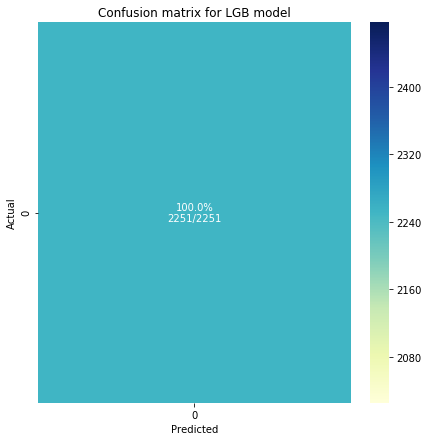

In [35]:
# Showing Confusion Matrix for LGB model
plot_cm(y_train_lgb, y, 'Confusion matrix for LGB model', figsize=(7,7))

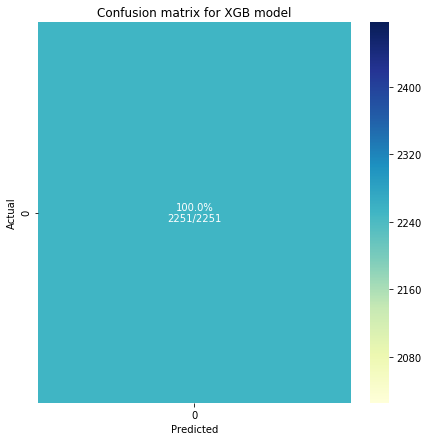

In [36]:
# Showing Confusion Matrix for XGB model
plot_cm(y_train_xgb, y, 'Confusion matrix for XGB model', figsize=(7,7))

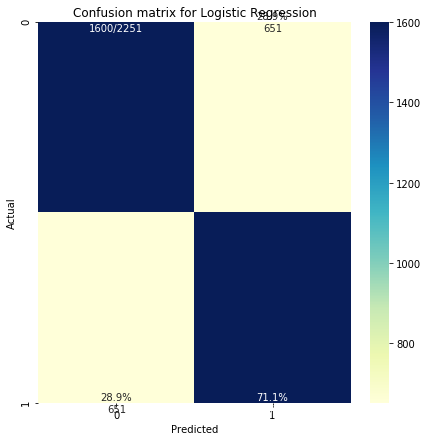

In [37]:
# Showing Confusion Matrix for Logistic Regression
plot_cm(y_logreg_train, y, 'Confusion matrix for Logistic Regression', figsize=(7,7))

In [52]:
# From the kernel https://www.kaggle.com/vbmokin/merging-fe-prediction-xgb-lgb-logr-linr
y_preds = w_lgb*y_preds_lgb + w_xgb*y_preds_xgb + w_logreg*y_logreg_pred

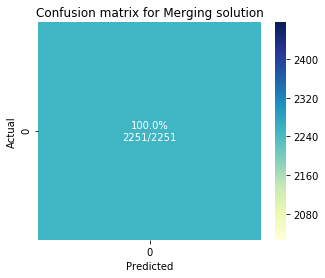

In [53]:
# Showing Confusion Matrix for Merging solution
y_train_preds = w_lgb*y_train_lgb + w_xgb*y_train_xgb + w_logreg*y_logreg_train
plot_cm(y_train_preds, y, 'Confusion matrix for Merging solution')

In [54]:
sub = pd.read_csv('MDataFiles_Stage1/MSampleSubmissionStage1_2020.csv')
MNCAATourneyCompactResults = pd.read_csv('MDataFiles_Stage1/MNCAATourneyCompactResults.csv')
sub = pd.concat([sub, sub['ID'].str.split('_', expand=True).rename(columns={0: 'Season', 
                                                                            1: 'Team1', 2: 'Team2'}).astype(np.int64)], axis=1)
merge = pd.merge(sub, MNCAATourneyCompactResults[['Season', 'WTeamID', 'LTeamID']], how='left', 
                 left_on=['Season', 'Team1', 'Team2'], right_on=['Season', 'WTeamID', 'LTeamID'])
sub.loc[~merge['WTeamID'].isnull(), 'Pred'] = 1
merge = pd.merge(sub, MNCAATourneyCompactResults[['Season', 'WTeamID', 'LTeamID']], 
                 how='left', left_on=['Season', 'Team2', 'Team1'], right_on=['Season', 'WTeamID', 'LTeamID'])
sub.loc[~merge['WTeamID'].isnull(), 'Pred'] = 0
sub = sub.drop(['Season', 'Team1', 'Team2'], axis=1)

In [55]:
sub['Pred'] = y_preds
sub.head()

,ID,Pred
0,2015_1107_1112,0.010337
1,2015_1107_1116,0.057666
2,2015_1107_1124,0.108574
3,2015_1107_1125,0.705924
4,2015_1107_1129,0.136398


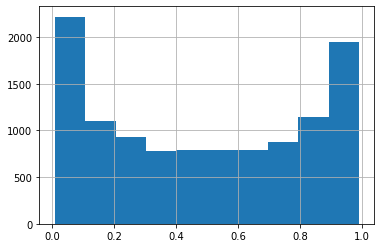

In [56]:
sub['Pred'].hist()

In [57]:
sub.to_csv('submission.csv', index=False)